# Looking for Spike Features at Threshold

In [1]:
%matplotlib inline
from allensdk.core.cell_types_cache import CellTypesCache
import matplotlib as mpl # I don't think I'm using this
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Lowest possible amplitude resting potential

In [14]:
def lowest_possible_amplitude(specimen_id,sweep_type):
    features = ctc.get_ephys_sweeps(specimen_id)
    sweep_list=[]
    sweep_stim_amp=[]
    for f in range(len(features)):
        if features[f]['stimulus_name'] == sweep_type:
            if features[f]['num_spikes'] > 0:
                sweep_list.append([features[f]['sweep_number'],f])
    for f in range(len(sweep_list)):
        sweep_stim_amp.append([sweep_list[f][0],features[sweep_list[f][1]]['stimulus_absolute_amplitude']])
        sweep_stim_amp.sort()
    return sweep_stim_amp[-1][0]

# Threshold Time

In [17]:
def get_threshold_time(spec_id,sweep):
    import h5py, os
    data_set = ctc.get_ephys_data(spec_id)
    f = h5py.File(data_set.file_name,'r')
    spike_times = f['analysis']['aibs_spike_times']['Sweep_%d' % sweep].value
    f.close()
    return spike_times[0]

# Load DataFrame from here

In [12]:
df1=np.load('cells_dataframe.h5')
#df_PV=df1(df1.Cre_Line=='Pvalb-IRES-Cre').copy()
ctc = CellTypesCache(manifest_file='e:\cell_types\manifest.json')

In [15]:
df1['Ramp_Sweep'] = None
df1['LS_Sweep'] = None
df1['SS_Sweep'] = None
for s in range(len(df1)):
    df1['SS_Sweep'].iloc[s] = lowest_possible_amplitude(df1['id'].iloc[s],'Short Square')
    df1['LS_Sweep'].iloc[s] = lowest_possible_amplitude(df1['id'].iloc[s],'Long Square')
    try:
        df1['Ramp_Sweep'].iloc[s] = lowest_possible_amplitude(df1['id'].iloc[s],'Ramp')
    except IndexError:
        continue

#Graph the Spikes
spike threshold is normalized to 0 mV

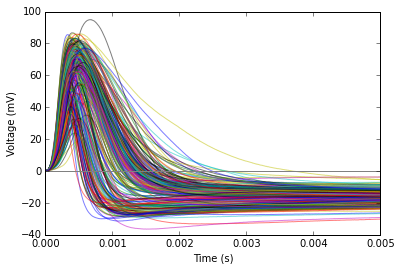

In [13]:
# input the dataframe column of the sweep type you want to graph
graph_type =

#Put full data set adjacent to the PV cells
def get_sweep_v_i_t_from_set(spec_id, sweep_number):
    data_set = ctc.get_ephys_data(spec_id)
    sweep_data = data_set.get_sweep(sweep_number)
    v = sweep_data["response"] # in V
    v *= 1e3 # to mV
    sampling_rate = sweep_data["sampling_rate"] # in Hz
    spike_time=int(get_threshold_time(spec_id,sweep_number)*sampling_rate)
    v[:] = [x +(-v[spike_time]) for x in v]
    v=v[spike_time:]
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)
    return v, t

 
for s in range(len(df1)):
    time_window = 0.005
    if df1[graph_type].iloc[s] != None:
        v, t = get_sweep_v_i_t_from_set(df1['id'].iloc[s],df1[graph_type].iloc[s])
    plt.plot(t, v,alpha=.2)
    plt.plot(t, color='gray')
    plt.xlim(0,time_window)
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")


# PCA (principle component analysis)
build Numpy Arrays for each sweep type

In [11]:
def normalized_sweep_PCA(spec_id, sweep_number):
    data_set = ctc.get_ephys_data(spec_id)
    sweep_data = data_set.get_sweep(sweep_number)
    v = sweep_data["response"] # in V
    v *= 1e3 # to mV
    sampling_rate = sweep_data["sampling_rate"] # in Hz
    spike_time=int(get_threshold_time(spec_id,sweep_number)*sampling_rate)
    v[:] = [x +(-v[spike_time]) for x in v]
    v=v[spike_time:spike_time+1000]
    return v

In [ ]:
PCA_SS_array = np.empty((len(df1),1000))
PCA_LS_array = np.empty((len(df1),1000))
PCA_RP_array = np.empty((len(df1),1000))

s = 0
for s in range(len(df1)):
    PCA_SS_array[s,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['SS_Sweep'].iloc[s])
    PCA_LS_array[s,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['LS_Sweep'].iloc[s])
    if df1['Ramp_Sweep'].iloc[s] != None:
        PCA_RP_array[s,:] = normalized_sweep_PCA(df1['id'].iloc[s],df1['Ramp_Sweep'].iloc[s])

In [ ]:
np.save('ephys_SS_PCA.npy',PCA_SS_array)
np.save('ephys_LS_PCA.npy',PCA_LS_array)
np.save('ephys_RP_PCA.npy',PCA_RP_array)

In [2]:
PCA_SS_array = np.load('ephys_SS_PCA.npy')
PCA_LS_array = np.load('ephys_LS_PCA.npy')
PCA_RP_array = np.load('ephys_RP_PCA.npy')

In [3]:
model_SS = PCA(5)
model_LS = PCA(5)
model_RP = PCA(5)


In [4]:
model_SS.fit(PCA_SS_array)
model_LS.fit(PCA_LS_array)
model_RP.fit(PCA_RP_array)

PCA(copy=True, n_components=5, whiten=False)

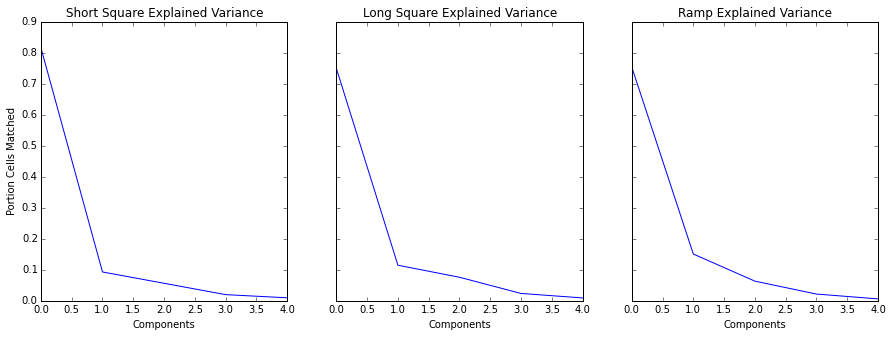

In [5]:
f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(15,5))
ax1.plot(model_SS.explained_variance_ratio_)
ax2.plot(model_LS.explained_variance_ratio_)
ax3.plot(model_RP.explained_variance_ratio_)
ax1.set_xlabel('Components')
ax2.set_xlabel('Components')
ax3.set_xlabel('Components')
ax1.set_title('Short Square Explained Variance')
ax2.set_title('Long Square Explained Variance')
ax3.set_title('Ramp Explained Variance')
ax1.set_ylabel('Portion Cells Matched')

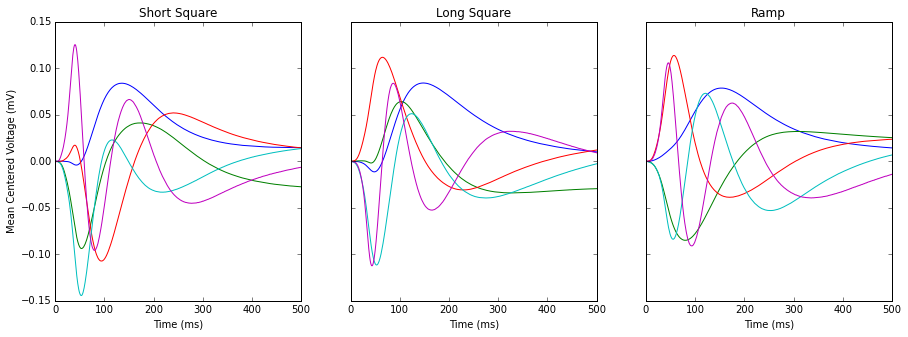

In [6]:
f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True,sharex=True,figsize=(15,5))
plt.title('PCA')
ax1.set_title('Short Square')
ax2.set_title('Long Square')
ax3.set_title('Ramp')
ax1.set_xlim(0,500)
#ax2.set_xlim(0,500)
ax1.plot(model_SS.components_.T);
ax1.set_ylabel('Mean Centered Voltage (mV)')
ax1.set_xlabel('Time (ms)')
ax2.set_xlabel('Time (ms)')
ax2.plot(model_LS.components_.T);
ax3.plot(model_RP.components_.T);
#ax3.set_xlim(0,500)
ax3.set_xlabel('Time (ms)')

In [7]:
mean_spike_SS = np.mean(PCA_SS_array,0)
mean_spike_LS = np.mean(PCA_LS_array,0)
mean_spike_RP = np.mean(PCA_RP_array,0)

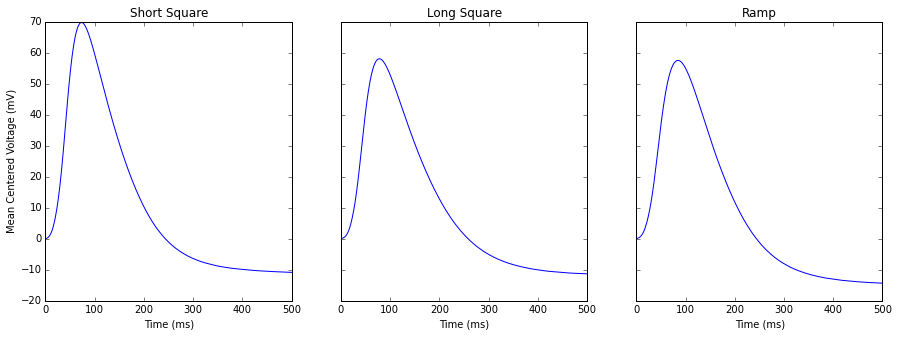

In [8]:
f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(15,5))
ax1.set_title('Short Square')
ax2.set_title('Long Square')
ax3.set_title('Ramp')
ax1.set_xlim(0,500)
ax2.set_xlim(0,500)
ax3.set_xlim(0,500)
ax1.plot(mean_spike_SS)
ax2.plot(mean_spike_LS)
ax3.plot(mean_spike_RP)
ax1.set_ylabel('Mean Centered Voltage (mV)')
ax1.set_xlabel('Time (ms)')
ax2.set_xlabel('Time (ms)')
ax3.set_xlabel('Time (ms)')

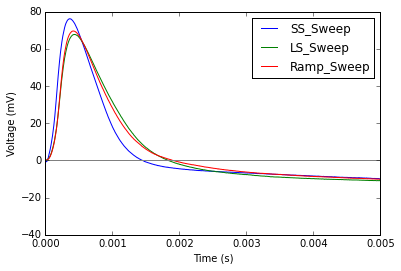

In [18]:
Sweeps = ['SS_Sweep','LS_Sweep','Ramp_Sweep']
for s in Sweeps:
    time_window = 0.005
    v, t = get_sweep_v_i_t_from_set(df1['id'].iloc[1],df1[s].iloc[1])
    plt.plot(t, v,label = s)
    plt.plot(t, color='gray')
    plt.xlim(0,time_window)
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")
plt.legend()

In [19]:
# initialized and run decomposition
model_SS_20 = PCA(20)
model_SS_20.fit(PCA_SS_array)
decomp = model_SS_20.fit_transform(PCA_SS_array)
sigma = np.sqrt(model_SS_20.explained_variance_)

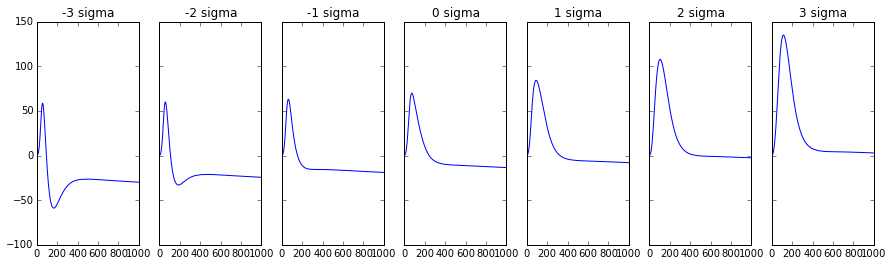

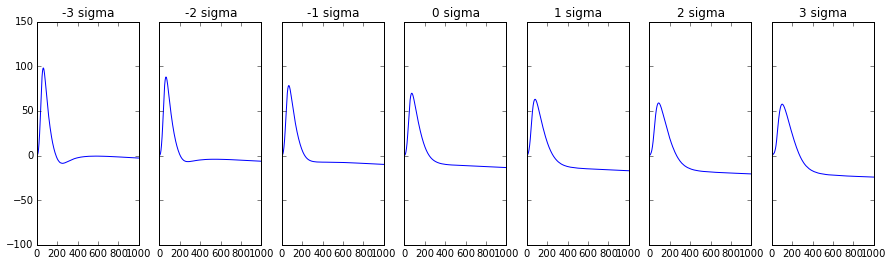

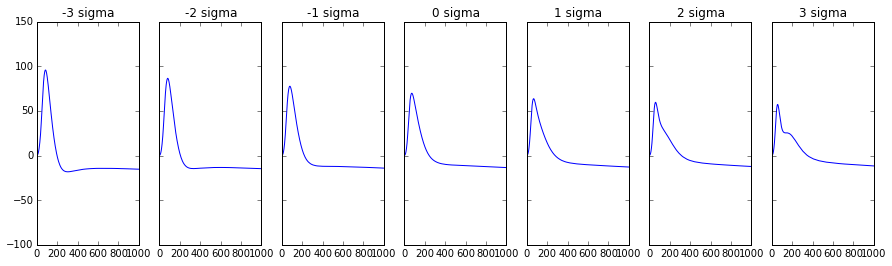

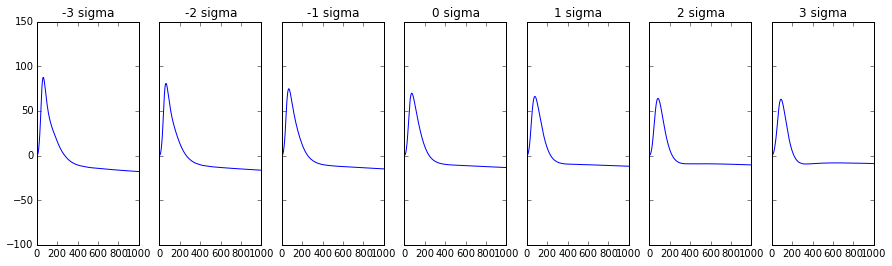

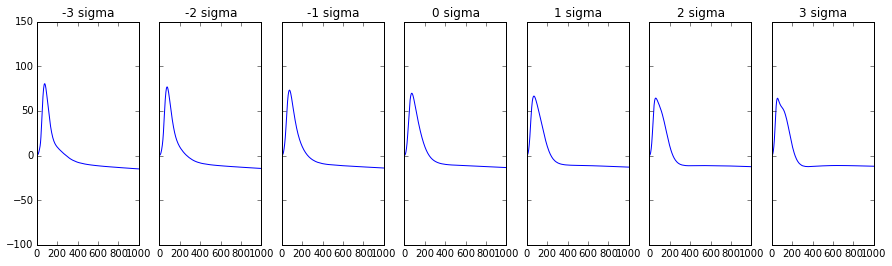

In [21]:
for c in range(5):
    f,ax = plt.subplots(1,7,sharey=True,figsize=(15,4))
    for idx, s in enumerate(range(-3,4)) :
        ax[idx].plot(model_SS_20.mean_ + s*sigma[c]*model_SS_20.components_[c])
        ax[idx].set_title('%d sigma' % s)
        #ax[idx].set_xlim(0,2600)
        ax[idx].set_ylim(-100,150)
    #plt.savefig('ss_components_sigma'+str(c)+'.png')

In [72]:
# associate trace data back to specimen_id
trace_df = df1
exp_lookup = [e['layer'][0]['specimen_id'] for idx,e in trace_df.iterrows()]

TypeError: string indices must be integers

In [55]:
print e

id                       324257146
mouse_line            Sst-IRES-Cre
region                        VISp
layer                            4
hemisphere                    left
dendrite_type               aspiny
apical                          NA
has_morphology                True
has_reconstruction            True
normalized_depth          0.410398
reference_space_id               9
y                          893.332
x                           7805.4
z                           3307.7
tau                       19.36609
...
average_contraction                 0.776329
average_bifurcation_angle_remote     77.4101
hausdorff_dimension                  1.12107
total_surface                        1416.64
max_branch_order                           6
soma_surface                         111.175
overall_height                       215.758
Ramp_Sweep                                 6
LS_Sweep                                  35
SS_Sweep                                  20
ephys_ss_00          

In [41]:
ncomp = 5
for c in range(ncomp):
    df1['ephys_ss_%02d' % c] = np.nan
    
start_label = 'ephys_ss_%02d' % 0
end_label = 'ephys_ss_%02d' % (ncomp-1)

In [44]:
for idx, e in enumerate(exp_lookup) :
    cells_df.ix[e, start_label:end_label] = np.divide(decomp[idx,0:ncomp],sigma[0:ncomp])

NameError: name 'exp_lookup' is not defined

In [50]:
df1.columns

Index([u'id', u'mouse_line', u'region', u'layer', u'hemisphere', u'dendrite_type', u'apical', u'has_morphology', u'has_reconstruction', u'normalized_depth', u'reference_space_id', u'y', u'x', u'z', u'tau', u'upstroke_downstroke_ratio_short_square', u'thumbnail_sweep_id', u'has_delay', u'threshold_v_ramp', u'peak_v_short_square', u'avg_isi', u'sag', u'blowout_voltage', u'trough_t_ramp', u'slow_trough_v_ramp', u'slow_trough_v_long_square', u'has_pause', u'electrode_0_pa', u'trough_v_long_square', u'input_resistance_mohm', u'latency', u'fast_trough_v_ramp', u'trough_t_long_square', u'threshold_t_long_square', u'rheobase_sweep_id', u'peak_t_ramp', u'threshold_t_short_square', u'has_burst', u'slow_trough_t_long_square', u'fast_trough_t_long_square', u'ri', u'threshold_v_short_square', u'upstroke_downstroke_ratio_ramp', u'vm_for_sag', u'threshold_i_long_square', u'initial_access_resistance', u'peak_t_long_square', u'threshold_i_short_square', u'threshold_v_long_square', u'peak_v_ramp', u'fas

,id,mouse_line,region,layer,hemisphere,dendrite_type,apical,has_morphology,has_reconstruction,normalized_depth,...,soma_surface,overall_height,Ramp_Sweep,LS_Sweep,SS_Sweep,ephys_ss_00,ephys_ss_01,ephys_ss_02,ephys_ss_03,ephys_ss_04
0,324257146,Sst-IRES-Cre,VISp,4,left,aspiny,NA,True,True,0.410398,...,111.175,215.758,6,35,20,NaN,NaN,NaN,NaN,NaN
1,469622566,Scnn1a-Tg3-Cre,VISp,5,right,spiny,truncated,True,False,0.423992,...,NaN,NaN,6,87,31,NaN,NaN,NaN,NaN,NaN
2,328876201,Sst-IRES-Cre,VISp,5,left,aspiny,NA,False,False,0.510874,...,NaN,NaN,7,43,22,NaN,NaN,NaN,NaN,NaN
3,466431949,Scnn1a-Tg3-Cre,VISl,4,left,spiny,truncated,True,False,0.464470,...,NaN,NaN,10,59,32,NaN,NaN,NaN,NaN,NaN
4,396903227,Scnn1a-Tg3-Cre,VISp,5,right,spiny,truncated,False,False,0.497223,...,NaN,NaN,6,48,22,NaN,NaN,NaN,NaN,NaN
5,469798159,Scnn1a-Tg3-Cre,VISp,4,left,spiny,intact,True,True,0.334733,...,474.195,388.731,6,51,32,NaN,NaN,NaN,NaN,NaN
6,471131311,Rbp4-Cre_KL100,VISp,5,right,spiny,intact,False,False,0.575692,...,NaN,NaN,7,48,23,NaN,NaN,NaN,NaN,NaN
7,348592897,Scnn1a-Tg2-Cre,VISp,4,left,spiny,intact,True,True,0.382884,...,689.158,573.602,6,56,37,NaN,NaN,NaN,NaN,NaN
8,469720505,Nr5a1-Cre,VISp,4,left,spiny,truncated,False,False,0.370184,...,NaN,NaN,6,54,28,NaN,NaN,NaN,NaN,NaN
9,464188580,Htr3a-Cre_NO152,VISp,2/3,left,aspiny,NA,True,True,0.216749,...,424.367,136.794,6,54,24,NaN,NaN,NaN,NaN,NaN
